# Atmosphere parameter testing!

Hypothesis: if we knew atmospheric parameters (Cn2, etc), we'd be able to predict the precise power spectrum of the atmosphere decently accurately.

Work from the 2019 Center for Adaptive Optics Fall Science Retreat, Keck Telemetry Hackathon.

## Steps

1. Check the coherence of the HCIPy-generated power spectra. That is, for fixed parameters, check that the power spectrum is the same/close enough to it over time.
2. Use HCIPy to generate the power spectrum for particular atmospheric parameters we know are on the Keck data.
3. Match to the true power spectrum from the Keck data.
4. Attempt to make a "truth power spectrum generator", i.e. a function that takes in known atmospheric parameters and returns a best guess of the power spectrum. 
5. Validate this on Keck data.
6. Make a big pile of linear algebra and work backwards to an empirical relationship between the truth power spectra and the optimal autoregressive model.

In [7]:
# utilities

import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

f_sampling = 1000

rms = lambda data: np.sqrt(np.mean(data ** 2))
psd = lambda data: signal.periodogram(data, fs=f_sampling)

In [2]:
# step 1: coherence of HCIPy

from aberrations import *

heights = np.array([500, 1000, 2000, 4000, 8000, 16000])
velocities = np.array([10, 10, 10, 10, 10, 10])
Cn_squared = np.array([0.2283, 0.0883, 0.0666, 0.1458, 0.3350, 0.1350]) * 1e-12

make_atmosphere = make_custom_atmospheric_layers(heights, velocities, Cn_squared)
layers = make_atmosphere(pupil_grid, L0=10)

tt_cms_zeroed = make_atm_data(2000, layers=layers)[:,0]
tt_cms_shifted = make_atm_data(2000, layers=layers, zerotime=500)[:,0]

(1e-07, 15.783531203058189)

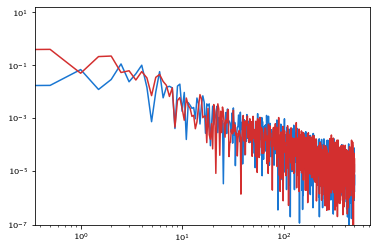

In [11]:
plt.loglog(*psd(tt_cms_zeroed), label='Unshifted')
plt.loglog(*psd(tt_cms_shifted), label='Shifted')
plt.ylim(1e-7)

Seems like HCIPy is decently coherent over time, but that could just be an oversimplification. Anyway, that's good enough to move on to step two!

In [23]:
# step 2: generate power spectra that we should see on the Keck data based on its atmospheric parameters.
# first, let's see what those atmospheric parameters even are.

from scipy import io
num = 128 # change this to 129-132 for others
filename = '../telemetry/n0' + str(num) + '_LGS_trs.sav'
telemetry = io.readsav(filename)
for key in telemetry.keys():
    try:
        print(key, telemetry[key].dtype)
    except AttributeError:
        print(key)

a (numpy.record, [(('conf_id', 'CONF_ID'), 'O'), (('timestamp', 'TIMESTAMP'), 'O'), (('subapintensity', 'SUBAPINTENSITY'), 'O'), (('offsetcentroid', 'OFFSETCENTROID'), 'O'), (('residualwavefront', 'RESIDUALWAVEFRONT'), 'O'), (('dmcommand', 'DMCOMMAND'), 'O'), (('dmcommandsclipped', 'DMCOMMANDSCLIPPED'), 'O'), (('residualrms', 'RESIDUALRMS'), 'O'), (('ttcommands', 'TTCOMMANDS'), 'O'), (('ttstraingauge', 'TTSTRAINGAUGE'), 'O'), (('ttcommandsclipped', 'TTCOMMANDSCLIPPED'), 'O')])
b (numpy.record, [(('conf_id', 'CONF_ID'), 'O'), (('timestamp', 'TIMESTAMP'), 'O'), (('apdcounts', 'APDCOUNTS'), 'O'), (('dttcentroids', 'DTTCENTROIDS'), 'O'), (('dttcommands', 'DTTCOMMANDS'), 'O'), (('dttstraingauge', 'DTTSTRAINGAUGE'), 'O'), (('dttcommandsclipped', 'DTTCOMMANDSCLIPPED'), 'O')])
uid >i4
cid >u4
nrec int32
rx >f4
cent_origin >f4
dm_origin >f4
dtt_offset >f4
tstamp_num >u8
tstamp_str_start
cent_g >f4
dm_servo >f4
dt_servo >f4
apd_imat >f4
apd_sky_back >f4
apd_threshold >f4
header object


In [30]:
telemetry['b']['apdcounts']

array([array([[107., 131.,  81., 132.],
       [ 99., 135.,  95., 142.],
       [100., 155., 100., 125.],
       ...,
       [ 93., 138.,  97., 130.],
       [ 92., 141.,  99., 141.],
       [ 92., 134.,  99., 126.]], dtype=float32)], dtype=object)

Oops. Stuck here. I don't know where the parameters I want are.

In [48]:
# step 4, unvalidated

# scale_cn2 is the multiplying factor on HCIPy's default cn2
make_layers = lambda scale_cn2: make_custom_atmospheric_layers(heights, velocities, scale_cn2 * Cn_squared)(pupil_grid, L0=10)
# I also don't quite know what L0 is

def get_cn2tt(scale, steps=2000):
    layers = make_layers(scale)
    return make_atm_data(steps, layers=layers)[:,0] # please excuse all the overloading of names

def show_cn2tt(scale, steps=2000, hold=False):
    tt_cms = get_cn2tt(scale, steps)
    plt.loglog(*psd(tt_cms), label=str(scale))
    if not hold:
        plt.show()

(1e-07, 10.819763061981998)

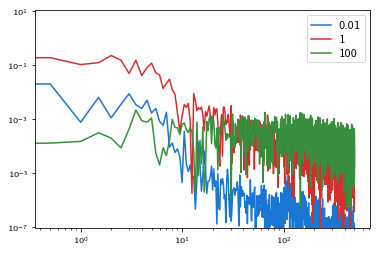

In [49]:
show_cn2tt(0.01,hold=True)
show_cn2tt(1,hold=True)
show_cn2tt(100,hold=True)
plt.legend()
plt.ylim(1e-7)

(1e-07, 0.024291001268202904)

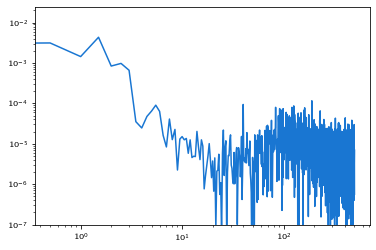

In [50]:
# that scale = 100 case looks a whole lot like a Keck data power spectrum. Including that weird high-freq peak.
# and the scale = 0.01 case looks a lot like what papers WANT a power spectrum to look like.
# let's formalize this.

from utils import *

_, _, keck_pol = get_keck_tts()
plt.loglog(*psd(keck_pol[:2000, 0]))
plt.ylim(1e-7)

In [51]:
psd_tofit = psd(keck_pol[:2000,0])[1]

In [56]:
# mcmc fitting: grabbing a whole bunch of things from my EECS 126 lab!
# using mcmc here instead of a straight scipy.optimize.minimize, because I might have to optimize other factors too

mcmc_fit_steps = 2000
mcmc_transitions = [-1, -0.5, -0.25, +0.25, +0.5, +1] 
# choose randomly from these for your next candidate's %change to CN2

def metropolis_hastings(proposal_func, init_func, acceptance_prob,
                        num_iters, step=30):
    samples = []
    state = init_func()
    num_proposals = 0
    for i in range(num_iters):
        candidate = proposal_func(state)
        if np.random.uniform(0, 1) < min(1, acceptance_prob(state, candidate)):
            state = candidate
        if i % step == 0:
            print(i)
            samples.append(state)
    
    return samples

starting_state = lambda: 1
def sample_candidate(sample):
    return sample * (1 + np.random.choice(mcmc_transitions))

def likelihood(scale):
    model = psd(get_cn2tt(scale, steps=mcmc_fit_steps))[1]
    return rms(model - psd_tofit)

def score(sample, candidate):
    return likelihood(candidate) / likelihood(sample)

samples = metropolis_hastings(sample_candidate, starting_state, score, 50, step=1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


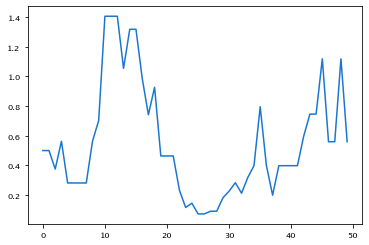

In [58]:
plt.plot(samples)